# Biol 359  |  Regularization
### Spring 2021, Week 8

<hr style="border:2px solid gray"> </hr>

Import necessary modules and libraries for the notebook.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import sklearn as sk
import urllib.request
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

sns.set(rc={'figure.figsize':(11.7,8.27)}) #change figure size
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
np.random.seed(0)

TITLE = {
        'fontsize':20,
        'fontweight':'bold'
    }

The following function generates random *in silico* data according to a defined response. Since this is an *in silico* exercise, we know the underlying model, or gold standard. The data derives from a 2nd order system.

In [2]:
def quadratic(x):
    # Default - 2x^2 + 2
    return 2*x**2 + 2

In [3]:
def generate_noisy_data(function, noise_std, n=10, measurement_std=.2, initial_value=0, x_max=3):
    """
    This function generates noisy data with a certain amount of error applied to the function response.
    The error is normally distributed around the noise_std.
    """
    x = np.linspace(0, x_max, n) 
    x_noise = np.random.normal(0, measurement_std, len(x))
    x += x_noise
    y_noise = np.random.normal(0, noise_std, len(x))
    y = function(x) + initial_value
    y += y_noise
    plt.plot(x, y, 'C0.', label='data')
    x_func = np.linspace(0, max(x)+measurement_std)
    y_func = function(x_func) + initial_value
    plt.plot(x_func, y_func, 'C0--', label='function')
    plt.fill_between(x_func, y_func+noise_std, y_func-noise_std,
                     alpha=0.1)          # Transparency of the fill
    plt.title(r'$ y = 2x^2 + 2$ with noise (std of {})'.format(noise_std), fontdict=TITLE)
    plt.legend(loc='best')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(0, max(x)+measurement_std)
    plt.show()
    return x, y


def plot_model(x, y, x_model, y_model, title = ''):
    """
    Plotter function.
    """
    plt.plot(x,y, 'o', label='data')
    plt.plot(x_model, y_model, '--', label='model')
    plt.legend(loc='best')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(0, max(x))
    plt.title(title)
    plt.show()
    return x, y



### 1. Standardize the data
Procedural note: **standardization** of data (taking the z-score by mean-centering and scaling data by its standard deviation) is required before performing regularization. An example of standardization is shown below. This code walks through the mathematics "under the hood" of `StandardScaler`.

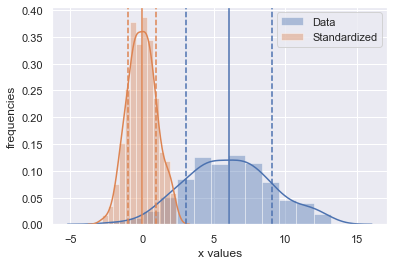

In [4]:
def zscore_plot(x):
    sns.distplot(x, label='Data')
    mean = np.mean(x)
    std = np.std(x)
    x_zscore = (x - mean)/(std)
    zscored_mean = np.mean(x_zscore)
    zscored_std = np.std(x_zscore)
    sns.distplot(x_zscore, label='Standardized')
    plt.xlabel('x values')
    plt.ylabel('frequencies')
    plt.axvline(mean, color='C0', linestyle='-')
    plt.axvline(mean + std, color='C0', linestyle='--')
    plt.axvline(mean - std, color='C0', linestyle='--')
    plt.axvline(zscored_mean, color='C1', linestyle='-')
    plt.axvline(zscored_mean+zscored_std, color='C1', linestyle='--')
    plt.axvline(zscored_mean-zscored_std, color='C1', linestyle='--')
    plt.legend(loc='best')
    plt.show()
    
x = np.random.normal(6, 3, 300)
zscore_plot(x)

Define necessary functions.

In [5]:
def polynomial_feature_example(x, y, regularization = None, reg_alpha=1, degrees=6):
    """
    Perform regularization on a polynomial feature set. 
    """
    poly_transform = PolynomialFeatures(degree=degrees, include_bias = False)
    x_poly = poly_transform.fit_transform(x.reshape(-1,1))
    
    #Regularization techniques need to be scaled in order to work properly
    x_scaler = StandardScaler().fit(x_poly)
    y_scaler = StandardScaler().fit(y.reshape(-1,1))
    x_poly_z = x_scaler.transform(x_poly)
    y_z = y_scaler.transform(y.reshape(-1,1))
    
    #Code to perform the model fitting and parameter estimation
    if regularization is None:
        #Least Squares problem
        plt.suptitle('Linear Regression', fontsize=20, fontweight='bold')
        lm_poly = linear_model.LinearRegression(fit_intercept=True)
        lm_poly.fit(x_poly_z,y_z)
        
    elif regularization is 'L1':
        #LASSO problem
        plt.suptitle('LASSO', fontsize=20, fontweight='bold')       
        lm_poly = linear_model.Lasso(alpha = reg_alpha, max_iter=1e8, fit_intercept=True)
        lm_poly.fit(x_poly_z,y_z)    
        
    elif regularization is 'L2':
        #ridge problem
        plt.suptitle('Ridge', fontsize=20, fontweight='bold')
        lm_poly = linear_model.Ridge(alpha = reg_alpha, max_iter=1e5, fit_intercept=True)
        lm_poly.fit(x_poly_z,y_z)
        
    x_model = np.linspace(min(x), max(x), 150).reshape(-1,1)
    x_model_transform = poly_transform.fit_transform(x_model)
    x_model_transform_z = x_scaler.transform(x_model_transform)
    
    
    y_model = lm_poly.predict(x_model_transform_z)*y_scaler.scale_ + y_scaler.mean_
    
    #********************************************************************************
    # Coefficients from scaled model can be transformed back into original units
    # This code is outside the scope of this class and can be ignored. 
    
    unscaled_coefficients = (lm_poly.coef_ * y_scaler.scale_ / x_scaler.scale_).flatten()
    
    poly_terms = [r'$({0:.3f})x ^ {{{1}}}$'.format(coef, i+1) for i, coef in enumerate(unscaled_coefficients)
                 if coef != 0]
    
    unscaled_intercept = lm_poly.intercept_*y_scaler.scale_ + y_scaler.mean_ \
                            - sum(unscaled_coefficients*x_scaler.mean_)
        
    intercept_str = r'${0:.1f} + $'.format(unscaled_intercept[0])
    title =  intercept_str + r'$+$'.join(poly_terms)
    #********************************************************************************
    
    plot_model(x_data, y_data, x_model, y_model, title=title)

### 2. Plot the *in silico* data and the true model. 

In [ ]:
x_data, y_data = generate_noisy_data(quadratic, 1, n=10)

### 3. Calculate the SLR coefficients for the *in silico* data generated above. 

In [ ]:
polynomial_feature_example(x_data, y_data, degrees=1)

### 4. Calculate the LASSO regression coefficients for the *in silico* data generated above. 

In [ ]:
polynomial_feature_example(x_data, y_data, regularization='L1', reg_alpha=0.01)

### 5. Calculate the Ridge regression coefficients for the *in silico* data generated above. 

In [ ]:
polynomial_feature_example(x_data, y_data, regularization='L2', reg_alpha = 0.01)

### 6. Significantly increase the number of observations, *n*, and re-calculate the regression coefficients. 
When the number of samples, *n*, is high, we do not impose the risk of overfitting as it is unlikely we would propose a model with *n*-degrees of freedom when *n>>0*. 


In [ ]:
x_data, y_data = generate_noisy_data(quadratic, 1, n=300)
polynomial_feature_example(x_data, y_data)
polynomial_feature_example(x_data, y_data, regularization='L1', reg_alpha= .1)
polynomial_feature_example(x_data, y_data, regularization='L2', reg_alpha = .1)